# Error Visualization

- Quantifying Errors
	- From Determined Test Cases,  
For each word, measure the number of *correctly* and *incorrectly* interpreted
- Classifying Errors
	- Miss interpretation of the words  
For each word, log the transcription, what is the the misinterpretation of the error  
→ calculate the occurence  
→ most common error for a given word


In [1]:
import os, pathlib
import numpy
import glob
import jiwer
import collections
import helper

# TODO: remove warning, put text preprocessing as helper


/home/masyrofi/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.semi_supervised.label_propagation module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.semi_supervised. Anything that cannot be imported from sklearn.semi_supervised is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/masyrofi/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelPropagation from version 0.18 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [2]:
class Data:

    def __init__(self, name):
        self.name = name
        self.reference = []
        self.transcription = []

    def preprocess_text(self, text):
        return helper.preprocess_text(text)

    def get_name(self):
        return self.name
    
    def get_reference(self):
        return self.reference

    def get_transcription(self):
        return self.transcription

    def add_reference(self, reference):
        self.reference.append(reference)
    
    def add_transcription(self, transcription):
        self.transcription.append(transcription)

    def add_reference_transcription(self, reference, transcription):
        self.add_reference(reference)
        self.add_transcription(transcription)
    
    def length(self):
        assert len(self.reference) == len(self.transcription)
        return len(self.reference)

    def print_reference_transcription(self, i):
        if i >= 0 and i < len(self.reference):
            print("Reference:   \t: ", self.reference[i])
            print("Transcription: \t: ", self.transcription[i])

    
    def print_head(self):
        self.print_reference_transcription(i=0)

    def print_tail(self):
        self.print_reference_transcription(i=self.length()-1)


In [3]:
LIBRISPEECH_TYPES = ["test-clean",
                    "test-other",
                    "dev-clean",
                    "dev-other"]

# LIBRISPEECH_TYPES = ["test-clean"]

# LIBRISPEECH_TYPES = ["test-other"]

# LIBRISPEECH_TYPES = ["dev-clean"]

# LIBRISPEECH_TYPES = ["dev-other"]


LIBRISPEECH_DIRS = []

for type in LIBRISPEECH_TYPES :
    LIBRISPEECH_DIRS.append(f"LibriSpeech/{type}/")


In [4]:
# ASR_NAME = "deepspeech"
ASR_NAME = "wav2vec2"

In [5]:
def read_librispeech_data():
    data = Data("librispeech")

    
    for librispeech_dir in LIBRISPEECH_DIRS:
        # librispeech_dir = "LibriSpeech/test-clean/"

        for filename in glob.iglob(librispeech_dir + '**/*.trans.txt', recursive=True):
            
            file = open(filename)

            for line in file.readlines():
                idx = line.split()[0]
                reference_text = " ".join(line.split()[1:])
                

                fid = "/".join(idx.split("-")[:-1]) # idx to file id

                fname = os.path.join(librispeech_dir, fid, idx)
                transcription_path = fname + "." + ASR_NAME + ".transcription.txt"
                if os.path.exists(transcription_path):
                    transcription = helper.read_transcription(transcription_path)
                    
                    # preprocess the text and transcription
                    reference_text = helper.preprocess_text(reference_text)
                    transcription = helper.preprocess_text(transcription)
                    
                    data.add_reference_transcription(reference_text, transcription)
                else:
                    raise ValueError("missing transcription: " + transcription_path)

            file.close()
        
    
    return data


In [6]:
data = read_librispeech_data()
data.print_head()
print()
data.print_tail()

Reference:   	:  eleven oclock had struck it was a fine clear night they were the only persons on the road and they sauntered leisurely along to avoid paying the price of fatigue for the recreation provided for the toledans in their valley or on the banks of their river
Transcription: 	:  eleven oclock had struck it was a fine clear night they were the only persons on the road and they sauntered leisurely along to avoid paying the price of fatigue for the recreation provided for the tuledans in the valley or on the banks of their river

Reference:   	:  now i wouldnt have felt that way
Transcription: 	:  now i wouldnt have felt that way


In [17]:
CROSSASR_TTS_NAME = "mac"
CROSSASR_TTS_VOICE = "Alex"


In [18]:
def read_corpus(corpus_fpath: str):
    file = open(corpus_fpath)
    corpus = file.readlines()
    texts = []
    for text in corpus:
        texts.append(text[:-1])

    return texts

def read_crossasr_data():
    data = Data("crossasr")

    # mode = "europarl"
    mode = "librispeech"

    corpus_fpaths = []
    transcription_dirs = []
    
    if mode == "europarl" :
        
        corpus_fpath = "CrossASR/europarl-seed2021/corpus/europarl-20000.txt"
        transcription_dir = "CrossASR/europarl-seed2021/data/transcription"
        
        corpus_fpaths.append(corpus_fpath)
        transcription_dirs.append(transcription_dir)
        
    elif mode == "librispeech" :

        for t in LIBRISPEECH_TYPES:
        
            corpus_fpath = f"CrossASR/librispeech-crossasr-{t}/corpus/librispeech-{t}-corpus.txt"
            transcription_dir = f"CrossASR/librispeech-crossasr-{t}/data/transcription"
            
            corpus_fpaths.append(corpus_fpath)
            transcription_dirs.append(transcription_dir)



    for corpus_fpath, transcription_dir in zip(corpus_fpaths, transcription_dirs):
    
        if CROSSASR_TTS_NAME == "mac" :
            transcription_dir = os.path.join(
                transcription_dir, CROSSASR_TTS_NAME, CROSSASR_TTS_VOICE, ASR_NAME)
        else :
            transcription_dir = os.path.join(transcription_dir, CROSSASR_TTS_NAME, ASR_NAME)

        references = read_corpus(corpus_fpath)
        
        for i in range(len(references)):
            if mode == "europarl" :
                transcription_path = os.path.join(transcription_dir, f"{i+1}.txt")
            elif mode == "librispeech" :
                transcription_path = os.path.join(transcription_dir, f"{i}.txt")
            transcription = helper.read_transcription(transcription_path)
            transcription = helper.preprocess_text(transcription)

            data.add_reference_transcription(references[i], transcription)

    return data



In [19]:
data = read_crossasr_data()
data.print_head()
print()
data.print_tail()

Reference:   	:  eleven oclock had struck it was a fine clear night they were the only persons on the road and they sauntered leisurely along to avoid paying the price of fatigue for the recreation provided for the toledans in their valley or on the banks of their river
Transcription: 	:  eleven oclock had struck it was a fine clear night they were the only persons on the road and they sauntered leisurely along to avoid pank the price of fatigue for the recreation provided for the tall dawn in their valley or on the banks of their river

Reference:   	:  now i wouldnt have felt that way
Transcription: 	:  now i wolld and have felt that way


In [20]:
from asr_evaluation.asr_evaluation import asr_evaluation

class Analyzer(object):

    
    def __init__(self):
        ## used for caching
        self.infos = {}
        self.word_count = {}
        self.word_accuracy = {}
        self.word_accuracy_with_count = {}
        self.common_errors = {}

        
    def analyze(self, data: Data):

        ## get from cache if it is already computed before
        if data.get_name() in self.infos :
            return self.infos[data.get_name()], self.word_count[data.get_name()]
        
        infos = []
        word_count = collections.Counter()
        
        for reference, transcription, in zip(data.get_reference(), data.get_transcription()) :
            
            ## create statistics for word counter
            word_count += collections.Counter(reference.split())
            
            ## create statistics for errors
            wer = jiwer.wer(reference, transcription)
            if wer != 0:
                evaluation = asr_evaluation.ASREvaluation()
                evaluation.detect_word_error(reference, transcription)
                confusion = evaluation.get_confusions()
                infos.append(
                    {"confusion": confusion, "reference": reference, "transcription": transcription})
        
        ## update the cache
        self.infos[data.get_name()] = infos
        self.word_count[data.get_name()] = word_count
        
        
        return infos, word_count

    def calculate_word_accuracy(self, data: Data):
        """Calculate word accuracy, which is the number of error (deletion or subsitution) divided by the number of word count

        """

        ## use caching if it is already computed before
        if data.get_name() in self.word_accuracy:
            return self.word_accuracy[data.get_name()]

        
        infos, word_count = self.analyze(data)
        error_count = collections.Counter()
        for info in infos:
            confusion = info["confusion"]

            ## get error from word substitution
            if len(confusion["substitution"]) > 0:
                
                curr_error_count = {}
                for i in range(len(confusion["substitution"])):
                    word_reference = confusion["substitution"][i]["word_reference"]
                    count = confusion["substitution"][i]["count"]

                    curr_error_count[word_reference] = count
                
                error_count += collections.Counter(curr_error_count)

            ## get error from word deletion
            if len(confusion["deletion"]) > 0:

                curr_error_count = {}
                for i in range(len(confusion["deletion"])):
                    word_reference = confusion["deletion"][i]["word"]
                    count = confusion["deletion"][i]["count"]

                    curr_error_count[word_reference] = count

                error_count += collections.Counter(curr_error_count)

        
        word_accuracy = {}
        word_accuracy_with_count = {}
        for word in word_count :
            
            ## if the word in the reference_text does not appear in the error word
            ## then all the occurence of the word is correctly predicted 
            if word not in error_count :
                word_accuracy[word] = 100.0 
                word_accuracy_with_count[word] = [100.0 , word_count[word]]
            else :
                curr_word_accuracy = 100.0 - (100 * round(error_count[word]/word_count[word], 2))
                assert curr_word_accuracy <= 100 and curr_word_accuracy >= 0
                word_accuracy[word] = curr_word_accuracy
                word_accuracy_with_count[word] = [curr_word_accuracy, word_count[word]]

        ## sort the word accuracy based on the word_accuracy
        word_accuracy = dict(sorted(word_accuracy.items(),
                                    key=lambda item: (item[1], item[0]), reverse=True))

        ## sort the word accuracy with count based on the word_accuracy
        word_accuracy_with_count = dict(sorted(word_accuracy_with_count.items(),
                                               key=lambda item: (item[1][0], -item[1][1], item[0]), reverse=False))

        
        ## update cache
        self.word_accuracy[data.get_name()] = word_accuracy
        self.word_accuracy_with_count[data.get_name()] = word_accuracy_with_count
        
        return word_accuracy

    def get_word_accuracy(self, dataset_name:str):
        if dataset_name in self.word_accuracy :
            return self.word_accuracy[dataset_name]
        return None

    def get_word_accuracy_with_count(self, dataset_name: str):
        if dataset_name in self.word_accuracy_with_count:
            return self.word_accuracy_with_count[dataset_name]
        return None


    def print_word_accuracy_with_minimum_count(self, data: Data, limit=0, minimium_count=10, ascending=True):
        
        if not data.get_name() in self.word_accuracy_with_count :
            self.calculate_word_accuracy(data)
        
        word_accuracy_with_count = self.word_accuracy_with_count[data.get_name()]
    
        keys = list(word_accuracy_with_count.keys())
        values = list(word_accuracy_with_count.values())
        print(f"{'Word':15s} {'Accuracy'} \tCount")
        
        j = 0
        for i in reversed(range(len(keys))) if ascending else range(len(keys)):
            if j < limit :
                if values[i][1] >= minimium_count :
                    print(f"{keys[i]:15s} {values[i][0]:} \t\t{values[i][1]:}")
                    j += 1


    def save_word_accuracy(self, dataset_name, fpath):
        word_accuracy = self.word_accuracy[dataset_name]
        os.makedirs(pathlib.Path(fpath).parent.absolute(), exist_ok=True)
        with open(fpath, 'w') as file:
            keys = list(word_accuracy.keys())
            values = list(word_accuracy.values())
            file.write(f"{'Word':15s} \t{'Accuracy'}\n")
            for i in range(len(keys)):
                file.write(f"{keys[i]:15s} \t{values[i]}\n")

    def save_word_accuracy_with_count(self, dataset_name, fpath):
        word_accuracy_with_count = self.word_accuracy_with_count[dataset_name]
        os.makedirs(pathlib.Path(fpath).parent.absolute(), exist_ok=True)
        with open(fpath, 'w') as file:
            keys = list(word_accuracy_with_count.keys())
            values = list(word_accuracy_with_count.values())
            file.write(f"{'Word':15s} \t{'Accuracy'} \tCount\n")
            for i in range(len(keys)):
                file.write(
                    f"{keys[i]:15s} \t{values[i][0]} \t{values[i][1]}\n")

    def print_lowest_word_accuracy(self, dataset_name, limit=10):
        word_accuracy = self.word_accuracy[dataset_name]
        keys = list(word_accuracy.keys())
        values = list(word_accuracy.values())
        print(f"{'Word':15s} {'Accuracy'}")
        for i in range(len(keys)-limit, len(keys)):
            print(f"{keys[i]:15s} {values[i]}")

    def print_highest_word_accuracy(self, dataset_name, limit=10):
        word_accuracy = self.word_accuracy[dataset_name]
        keys = list(word_accuracy.keys())
        values = list(word_accuracy.values())
        print(f"{'Word':15s} {'Accuracy'}")
        for i in range(limit):
            print(f"{keys[i]:15s} {values[i]}")


    def get_most_common_errors(self, data: Data):
        
        
        ## geta result from caching if it is already computed before
        if data.get_name() in self.common_errors:
            return self.common_errors[data.get_name()]


        infos, _ = self.analyze(data)

        ## TODO: use Counter library
        common_errors = {}
        for info in infos:
            confusion = info["confusion"]
            if len(confusion["substitution"]) > 0:
                for i in range(len(confusion["substitution"])):
                    word_reference = confusion["substitution"][i]["word_reference"]
                    word_substitution = confusion["substitution"][i]["word_substitution"]
                    count = confusion["substitution"][i]["count"]

                    if word_reference == "and" and word_substitution == "terrified":
                        print(info["reference"])
                        print(info["transcription"])


                    if word_reference in common_errors:
                        substitutions = common_errors[word_reference]
                        if word_substitution in substitutions:
                            common_errors[word_reference][word_substitution] = count + \
                                common_errors[word_reference][word_substitution]
                        else:
                            common_errors[word_reference][word_substitution] = count
                    else:
                        common_errors[word_reference] = {
                            word_substitution: count}

        ## sort things inside the common error
        for key in common_errors.keys():
            common_errors[key] = dict(sorted(common_errors[key].items(),
                                            key=lambda item: item[1], reverse=True))

        ## sort words based on the highest occurence
        common_errors = dict(sorted(common_errors.items(),
                                        key=lambda item: list(item[1].values())[0], reverse=True))
        
        self.common_errors[data.get_name()] = common_errors
        
        return common_errors

    def print_common_error(self, common_errors, limit=2):
        count = 0
        print_limit = 16
        for word, common in common_errors.items():
            if count < print_limit :
                print("Word: ", word)
                # print("Substituion: ")
                keys = list(common.keys())
                values = list(common.values())
                for i in range(min(limit, len(keys))):
                    print(f"\t{keys[i]:10s} count: {values[i]}")
            count += 1

    def save_common_errors(self, common_errors, fpath):
        os.makedirs(pathlib.Path(fpath).parent.absolute(), exist_ok=True)
        with open(fpath, 'w') as file:
            for word, common in common_errors.items():
                file.write(f"Word: {word}\n")
                keys = list(common.keys())
                values = list(common.values())
                for i in range(len(keys)):
                    file.write(f"\t{keys[i]:10s} count: {values[i]}\n")
            


In [21]:
analyzer = Analyzer()

data = read_librispeech_data()

analyzer.calculate_word_accuracy(data)
word_accuracy = analyzer.get_word_accuracy(data.get_name())

fpath = "output/librispeech/word_accuracy.txt"
analyzer.save_word_accuracy(data.get_name(), fpath)

fpath = "output/librispeech/word_accuracy_with_count.txt"
analyzer.save_word_accuracy_with_count(data.get_name(), fpath)


print("=== Lowest Accuracy Rate")
analyzer.print_lowest_word_accuracy(data.get_name())
print()

print("=== Highest Accuracy Rate")
analyzer.print_highest_word_accuracy(data.get_name())
print()


=== Lowest Accuracy Rate
Word            Accuracy
abolitionists   0.0
abolish         0.0
abeyance        0.0
abed            0.0
abdera          0.0
abbess          0.0
abalones        0.0
abalone         0.0
abaft           0.0
aaron           0.0

=== Highest Accuracy Rate
Word            Accuracy
zoology         100.0
zoologist       100.0
zoof            100.0
zest            100.0
zealand         100.0
zeal            100.0
zaman           100.0
yulka           100.0
yule            100.0
youthful        100.0



In [ ]:
analyzer.print_word_accuracy_with_minimum_count(data, limit=20, minimium_count=10)


Word            Accuracy 	Count
professor       100.0 		10
president       100.0 		10
occasionally    100.0 		10
feast           100.0 		10
express         100.0 		10
carrying        100.0 		10
begins          100.0 		10
powder          100.0 		11
national        100.0 		11
managed         100.0 		11
hester          100.0 		11
ball            100.0 		11
mystery         100.0 		12
mentioned       100.0 		12
images          100.0 		12
charlotte       100.0 		12
regiment        100.0 		13
appointed       100.0 		13
wandering       100.0 		14
flesh           100.0 		14


In [ ]:
print("=== Most common errors")
common_errors = analyzer.get_most_common_errors(data)
fpath = "output/librispeech/common_errors.txt"
analyzer.save_common_errors(common_errors, fpath)
analyzer.print_common_error(common_errors)
print()


=== Most common errors
Word:  in
	and        count: 131
	to         count: 7
Word:  a
	the        count: 111
	of         count: 10
Word:  and
	in         count: 96
	an         count: 16
Word:  the
	a          count: 78
	to         count: 11
Word:  this
	the        count: 67
	his        count: 5
Word:  too
	to         count: 33
	two        count: 5
Word:  that
	the        count: 26
	at         count: 10
Word:  an
	and        count: 25
	the        count: 6
Word:  is
	as         count: 21
	was        count: 15
Word:  their
	the        count: 19
	her        count: 7
Word:  two
	to         count: 19
	lotto      count: 1
Word:  of
	a          count: 19
	in         count: 7
Word:  o
	oh         count: 18
	of         count: 6
Word:  it
	i          count: 17
	he         count: 10
Word:  at
	and        count: 16
	a          count: 8
Word:  you
	he         count: 16
	i          count: 7



In [ ]:
data = read_crossasr_data()

# analyzer = Analyzer()
analyzer.calculate_word_accuracy(data)
word_accuracy = analyzer.get_word_accuracy(data.get_name())

fpath = "output/crossasr/word_accuracy.txt"
analyzer.save_word_accuracy(data.get_name(), fpath)

fpath = "output/crossasr/word_accuracy_with_count.txt"
analyzer.save_word_accuracy_with_count(data.get_name(), fpath)


print("=== Lowest Accuracy Rate")
analyzer.print_lowest_word_accuracy(data.get_name())
print()

print("=== Highest Accuracy Rate")
analyzer.print_highest_word_accuracy(data.get_name())
print()


=== Lowest Accuracy Rate
Word            Accuracy
abyssinians     0.0
absorb          0.0
aboriginal      0.0
abner           0.0
abed            0.0
abdera          0.0
abbess          0.0
abalone         0.0
abaft           0.0
aaron           0.0

=== Highest Accuracy Rate
Word            Accuracy
zoology         100.0
zoologist       100.0
zodiac          100.0
zest            100.0
zealand         100.0
zeal            100.0
youthful        100.0
youngest        100.0
yorkshire       100.0
york            100.0



In [ ]:
print("=== Most common errors")

common_errors = analyzer.get_most_common_errors(data)
fpath = "output/crossasr/common_errors.txt"
analyzer.save_common_errors(common_errors, fpath)

analyzer.print_common_error(common_errors)
print()


=== Most common errors
Word:  and
	in         count: 159
	on         count: 6
Word:  as
	is         count: 140
	his        count: 20
Word:  the
	that       count: 64
	there      count: 25
Word:  was
	with       count: 56
	as         count: 16
Word:  them
	him        count: 55
	the        count: 10
Word:  who
	he         count: 53
	you        count: 15
Word:  a
	the        count: 50
	and        count: 21
Word:  are
	a          count: 48
	and        count: 29
Word:  too
	to         count: 41
	two        count: 17
Word:  im
	in         count: 38
	him        count: 11
Word:  at
	it         count: 36
	that       count: 7
Word:  you
	he         count: 35
	i          count: 20
Word:  their
	the        count: 33
	there      count: 9
Word:  our
	a          count: 30
	are        count: 4
Word:  an
	in         count: 28
	and        count: 23
Word:  thee
	the        count: 27
	he         count: 5



In [ ]:
analyzer.print_word_accuracy_with_minimum_count(
    data, limit=20, minimium_count=10)


Word            Accuracy 	Count
wearing         100.0 		10
visitor         100.0 		10
violin          100.0 		10
van             100.0 		10
valley          100.0 		10
union           100.0 		10
uncertain       100.0 		10
twelve          100.0 		10
tower           100.0 		10
thousands       100.0 		10
tail            100.0 		10
strain          100.0 		10
signal          100.0 		10
seriously       100.0 		10
sees            100.0 		10
sacrifice       100.0 		10
remarkable      100.0 		10
religious       100.0 		10
related         100.0 		10
reflection      100.0 		10


## Insight 

It seems hard to compare the words intersection one-by-one. 
We will try qeurying the statistic for each word that has much error in CrossASR
Then get corresponding statistic from Librispeech data

### Combining Word Accuracy from the Two Results


In [ ]:
cr_data = read_crossasr_data()   ## crossasr dataq
ls_data = read_librispeech_data()   ## librispeech data

analyzer = Analyzer()

analyzer.calculate_word_accuracy(cr_data)
analyzer.calculate_word_accuracy(ls_data)


cr_word_acc = analyzer.get_word_accuracy_with_count(cr_data.get_name())
ls_word_acc = analyzer.get_word_accuracy_with_count(ls_data.get_name())

#### For each error in librispeech word accuracy, inform the corresponding error on the crossasr 

In [ ]:
import pandas as pd
df = pd.DataFrame(columns=["word", "ls_word_acc",
                  "cr_word_acc", "ls_word_count",  "cr_word_count"])
for word in ls_word_acc :
    if word in cr_word_acc :
        df = df.append({"word": word,
                        "ls_word_acc": round(ls_word_acc[word][0], 2),
                        "cr_word_acc": round(cr_word_acc[word][0], 2),
                        "ls_word_count": ls_word_acc[word][1],
                        "cr_word_count": cr_word_acc[word][1]
                        }, ignore_index=True)
    else :
        df = df.append({"word": word,
                        "ls_word_acc": round(ls_word_acc[word][0],2), 
                        "cr_word_acc" : -1,
                        "ls_word_count": ls_word_acc[word][1],
                        "cr_word_count": -1
                   }, ignore_index=True)

df


,word,ls_word_acc,cr_word_acc,ls_word_count,cr_word_count
0,lelechka,0.0,0.0,35,35
1,fauchelevent,0.0,0.0,24,24
2,dickie,0.0,4.0,23,23
3,leslie,0.0,91.0,23,23
4,serafima,0.0,0.0,23,23
...,...,...,...,...,...
17077,yesterdays,100.0,100.0,1,1
17078,zepplin,100.0,0.0,1,1
17079,zodiac,100.0,100.0,1,1
17080,zoologist,100.0,100.0,1,1


In [ ]:
## check the row to ensure ls_word_count == cr_word_count
df[df.apply(lambda x: x.ls_word_count != x.cr_word_count, axis=1)]


,word,ls_word_acc,cr_word_acc,ls_word_count,cr_word_count


In [ ]:
## filtering non english words

import nltk

english_word_corpus = set(nltk.corpus.words.words())

df = df[df["word"].apply(lambda x: x in english_word_corpus)]


In [ ]:
df.to_csv("output/combined_word_accuracy.csv")

## Error Visualization

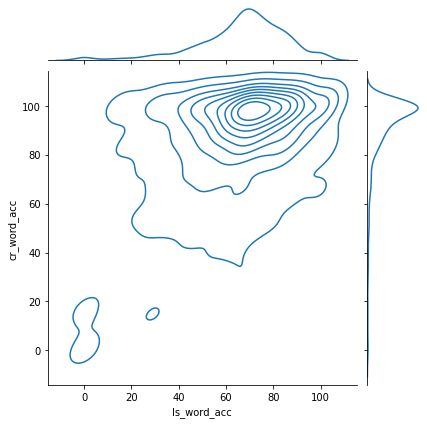

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt


# sns.scatterplot(data=df, x="ls_word_acc", y="cr_word_acc").set(title="Correlation of Word Accuracy")
# sns.jointplot(data=df, x="ls_word_acc", y="cr_word_acc", kind="hist")
# sns.jointplot(data=df, x="ls_word_acc", y="cr_word_acc", kind="kde")
sns.jointplot(data=df[df["ls_word_count"] > 5], x="ls_word_acc", y="cr_word_acc", kind="kde")


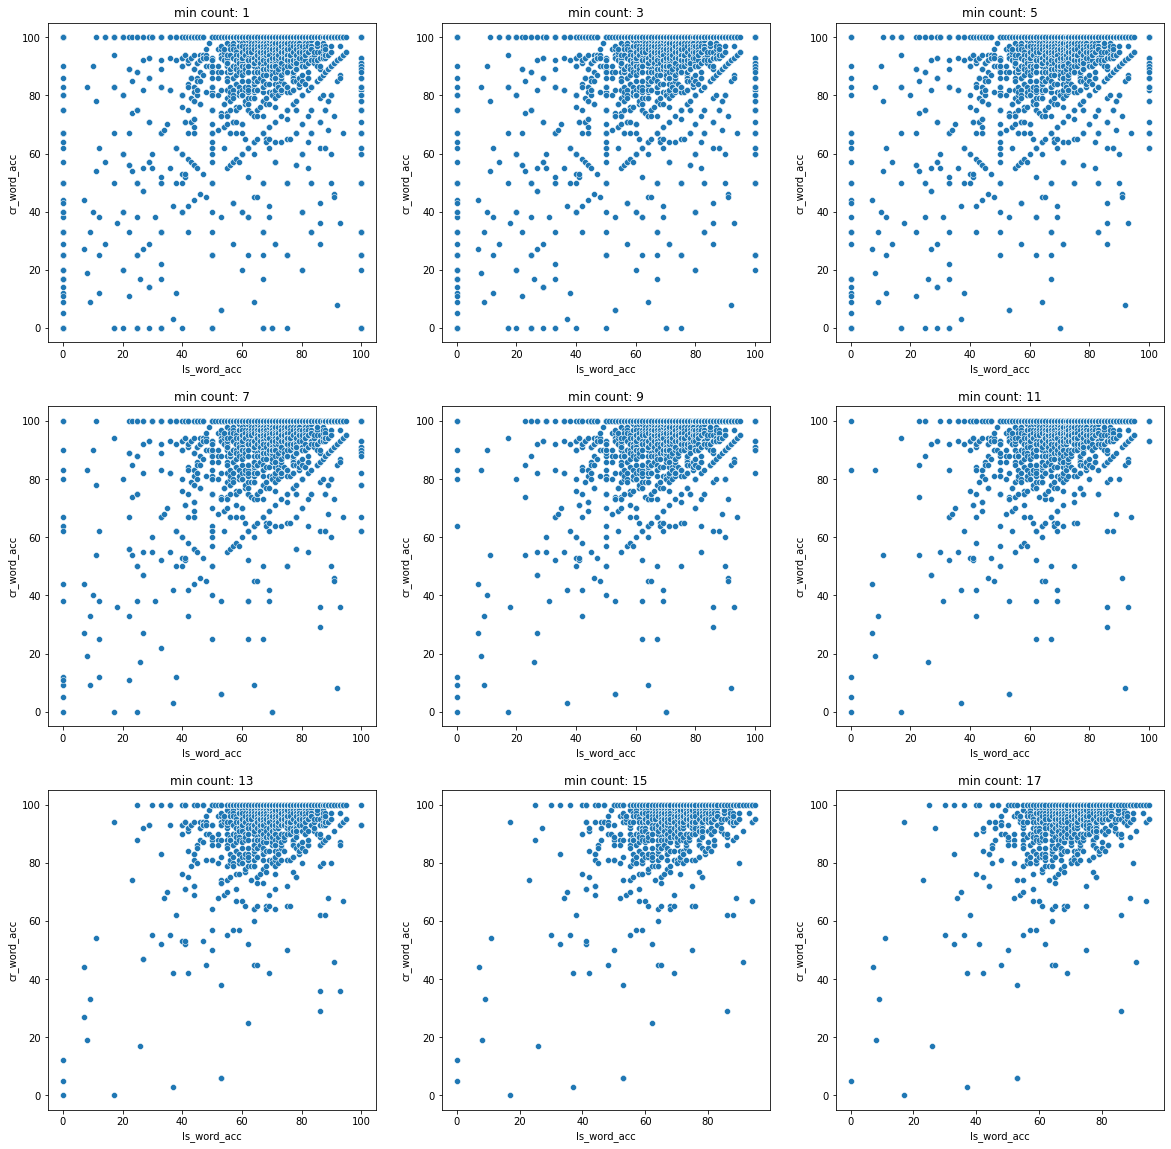

In [ ]:
## correlation with minimum count
min_count = [1, 3, 5, 7, 9, 11, 13, 15, 17]

M = 3 
N = 3
fig, axes = plt.subplots(M, N, figsize=(20, 20))

for i in range(M) :
    for j in range(N) :
        k = i*M + j
        sns.scatterplot(ax=axes[i,j], 
                        data=df[df["ls_word_count"] > min_count[k]],
                        x="ls_word_acc", 
                        y="cr_word_acc").set(
                                        title=f"min count: {min_count[k]}")


In [ ]:
### try derive more feature by finding the size of occurence
curr_df = df.groupby(["ls_word_acc", "cr_word_acc"]).size().reset_index(name="size")
curr_df


,ls_word_acc,cr_word_acc,size
0,0.0,0.0,887
1,0.0,5.0,1
2,0.0,9.0,1
3,0.0,11.0,1
4,0.0,12.0,1
...,...,...,...
763,100.0,89.0,1
764,100.0,90.0,2
765,100.0,91.0,2
766,100.0,93.0,2


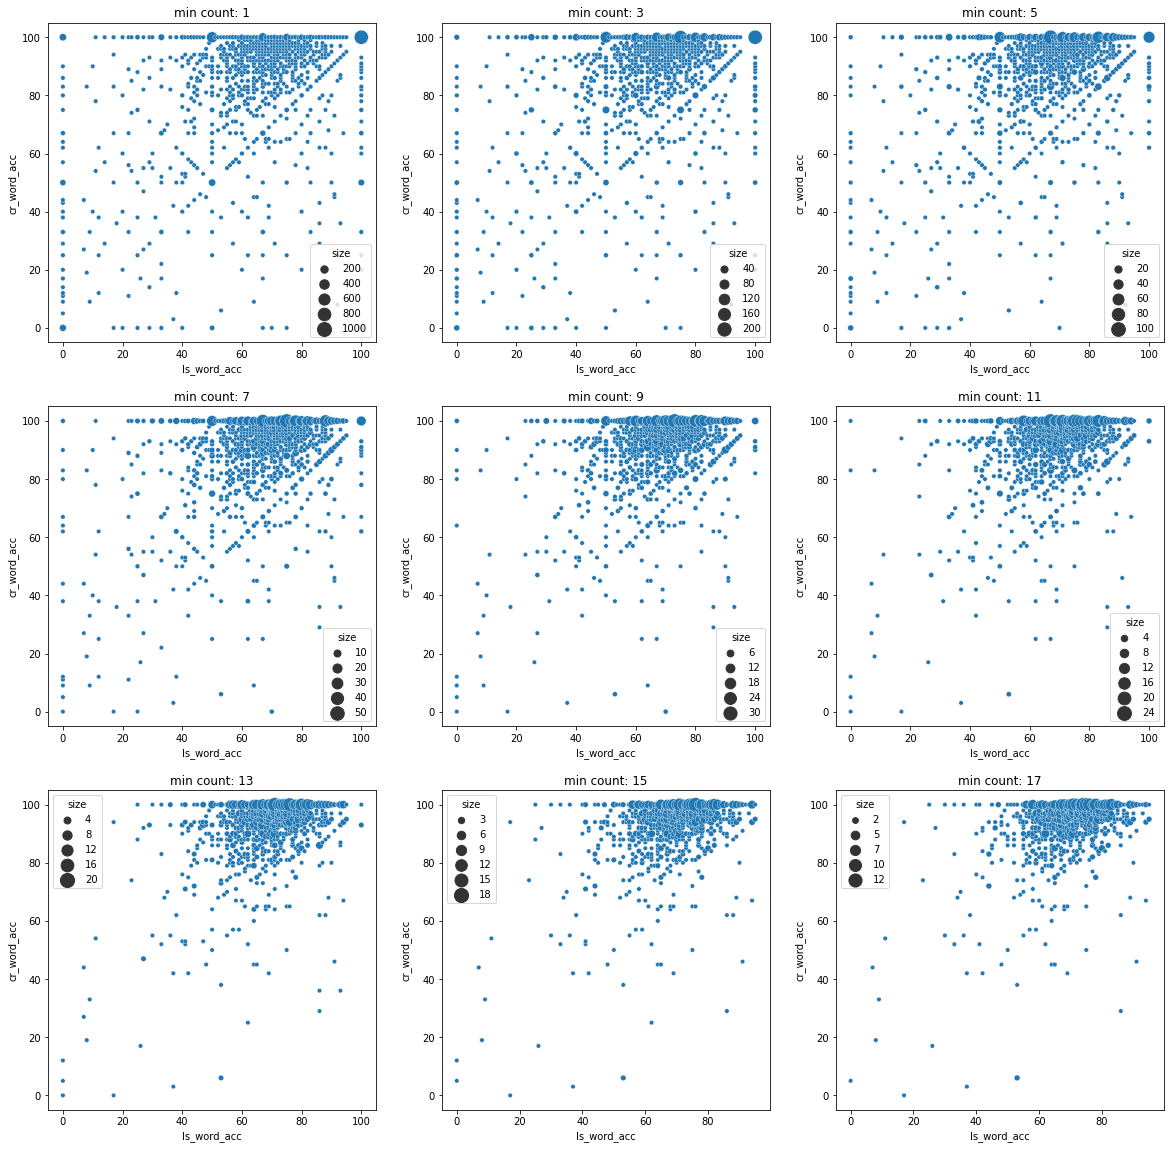

In [ ]:
## correlation with minimum count
min_count = [1, 3, 5, 7, 9, 11, 13, 15, 17]

M = 3
N = 3
fig, axes = plt.subplots(M, N, figsize=(20, 20))

for i in range(M):
    for j in range(N):
        k = i*M + j

        curr_df = df[df["ls_word_count"] > min_count[k]]
        curr_df = curr_df.groupby(["ls_word_acc", "cr_word_acc"]
                             ).size().reset_index(name="size")

        sns.scatterplot(ax=axes[i, j],
                        data=curr_df,
                        x="ls_word_acc",
                        y="cr_word_acc", 
                        size="size", sizes=(20, 200)).set(
            title=f"min count: {min_count[k]}")


## Pearson Correlation Test

In [ ]:
import scipy

# scipy.stats.pearsonr(df["ls_word_acc"], df["cr_word_acc"])
scipy.stats.mannwhitneyu(df["ls_word_acc"], df["cr_word_acc"])


MannwhitneyuResult(statistic=108454604.5, pvalue=0.0)

In [ ]:

stat = pd.DataFrame(columns=["bin_interval", "pearson_corr"]) 


n_bins = [1, 2, 4, 5, 10]

for n_bin in n_bins :
    bin_interval = int(100/n_bin)

    for i in range(n_bin):
        lower_bound = i * bin_interval
        upper_bound = lower_bound + bin_interval
        curr_df = df[df["cr_word_acc"].apply(
            lambda x: x >= lower_bound and x < upper_bound)]
        stat = stat.append(
            {
                "bin_interval": f"{int(lower_bound)}-{int(upper_bound)}",
                "pearson_corr": scipy.stats.pearsonr(curr_df["ls_word_acc"], curr_df["cr_word_acc"])[0]}, ignore_index=True)

stat


,bin_interval,pearson_corr
0,0-100,0.473850
1,0-50,0.120897
2,50-100,0.279127
3,0-25,0.009549
4,25-50,0.072285
5,50-75,0.084543
6,75-100,0.194047
7,0-20,0.002272
8,20-40,0.072979
9,40-60,0.026239


In [ ]:
stat.to_csv("output/pearson_correlation.csv")

In [ ]:
lower_bound = 0
upper_bound = 10

curr_df = df[df["ls_word_acc"].apply(
    lambda x: x >= lower_bound and x < upper_bound)]


In [ ]:
curr_df

,word,ls_word_acc,cr_word_acc,ls_word_count,cr_word_count
0,lelechka,0.0,0.0,35,35
1,fauchelevent,0.0,0.0,24,24
2,dickie,0.0,4.0,23,23
3,leslie,0.0,91.0,23,23
4,serafima,0.0,0.0,23,23
...,...,...,...,...,...
5006,altar,8.0,83.0,12,12
5007,o,9.0,33.0,85,85
5008,albert,9.0,82.0,11,11
5009,phoebe,9.0,9.0,11,11


In [ ]:
scipy.stats.pearsonr(curr_df["ls_word_acc"], curr_df["cr_word_acc"])


(-0.007846578110607077, 0.5786779764354835)